# CIR Model to simulate changes in interest Rate and Liability Hedging

The Cox Ingersoli Ross model is used to model the dynamics of interest rates and is an extension of the popular Vasicek model to prevent interest rates:

$$dr_t = a(b-r_t)dt + \sigma \sqrt{r_t}dW_t$$

where: 

$a$ = the speed of the mean reversion factor 

$b$ = the long term interest rate

## Short Rate vs Annualized

In General compunding N times a Year will yeild:

$$\left(1+\frac{r}{N}\right)^{N}$$

as N becomes very large the interest compunded continuously will yeild:

$$ 1+r_{annual} = e^r$$

In [1]:
import pandas as pd
import numpy as np
import edhec_risk_kit as erk
import math
%load_ext autoreload
%autoreload 2

def inst_to_ann(r):
    """
    Converst short rate to annualized rate
    """
    return np.expm1(r)

def ann_to_inst(r):
    """
    converst annualiex rate to short rate
    """
    return np.log1p(r)

$$dr_t = a(b-r_t)dt + \sigma \sqrt{r_t}dW_t$$

In [35]:
def cir(n_years = 10, n_scenarios = 1, a = .05, b = .03, sigma = .05, steps_per_year = 12, r_0 = None):
    """
    Implements the CIR model for interest rate
    """
    
    if r_0 is None:r_0 = b
    r_0 = ann_to_inst(r_0)
    dt = 1/steps_per_year
    
    num_steps = int(n_years * steps_per_year) + 1
    shock = np.random.normal(0,scale = np.sqrt(dt), size = (num_steps,n_scenarios))
    rates = np.empty_like(shock)
    rates[0] = r_0
    for step in range(1,num_steps):
        r_t = rates[step - 1]
        d_r_t = a*(b-r_t) * dt + sigma* np.sqrt(r_t) * shock[step]
        
        rates[step] = abs(r_t + d_r_t)
        
    return pd.DataFrame(data = inst_to_ann(rates), index = range(num_steps))

<AxesSubplot:>

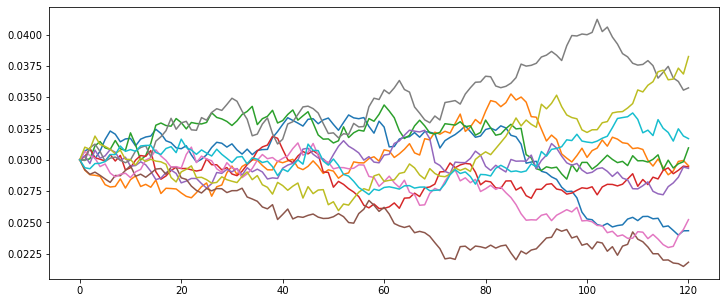

In [40]:
cir(n_scenarios = 10, sigma = .01).plot(legend = False,figsize = (12,5))

The model can also be used to generate movement of bond prices for a zero coupon bond that are implied by the generated interest rate using the following 

$$P(t,T) = A(t,T)e^{-B(t,T)r_t}$$

Where:

$$A(t,T) = \left(\frac{2he^{(a+h)\tau /2}}{2h+ (a+h)(e^{\tau h} - 1)}\right)^{2ab / \sigma^{2}}$$

and

$$ B(t,T) = \frac{2(e^{\tau h } - 1)}{2h + (a+h)(e^{\tau h } - 1)}$$

and

$$ h = \sqrt{a^2 + 2 \sigma ^ 2}$$

and 

$$ \tau = T-t  $$

In [71]:
def cir(n_years = 10, n_scenarios = 1, a = .05, b = .03, sigma = .05, steps_per_year = 12, r_0 = None):
    """
    Implements the CIR model for interest rate
    """
    
    if r_0 is None:r_0 = b
    r_0 = ann_to_inst(r_0)
    dt = 1/steps_per_year
    
    num_steps = int(n_years * steps_per_year) + 1
    shock = np.random.normal(0,scale = np.sqrt(dt), size = (num_steps,n_scenarios))
    rates = np.empty_like(shock)
    rates[0] = r_0
    
    #For Price Generation
    h = np.sqrt(a**2 + 2 * sigma **2)
    prices = np.empty_like(shock)
    
    def price(ttm,r):
        _A = ((2*h*math.exp((h+a)*ttm/2))/(2*h+(h+a)*(math.exp(h*ttm)-1)))**(2*a*b/sigma**2)
        _B = (2*(math.exp(h*ttm)-1))/(2*h + (h+a)*(math.exp(h*ttm)-1))
        _P = _A*np.exp(-_B*r)
        
        return _P
    prices[0] = price(n_years,r_0)
    
    for step in range(1,num_steps):
        r_t = rates[step - 1]
        d_r_t = a*(b-r_t) * dt + sigma* np.sqrt(r_t) * shock[step]
        rates[step] = abs(r_t + d_r_t)
        prices[step] = price(n_years - step*dt,rates[step])
        
        
    rates = pd.DataFrame(data = inst_to_ann(rates), index = range(num_steps)) 
    prices = pd.DataFrame(data = prices, index = range(num_steps))
    
    return rates, prices

<AxesSubplot:>

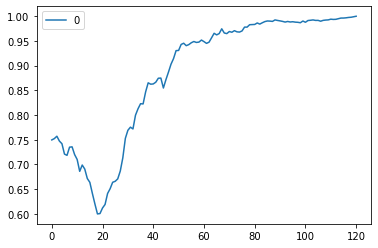

In [72]:
cir(10, n_scenarios = 1)[1].plot()